Capstone Project Deteksi Sampah (Bangkit 2024 Batch 1)

1. Import Required Libray

In [2]:
!pip install split-folders
!pip install opencv-python-headless

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import splitfolders
from tensorflow import keras
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from sklearn import metrics

2. Load and Split Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = "/content/drive/MyDrive/Gambar Sampah"

In [6]:
class_names = sorted(os.listdir(dataset_path))
print(class_names)

['kaca', 'karton', 'kertas', 'logam', 'organik', 'plastik']


In [7]:
class_dis = [len(os.listdir(dataset_path + f"/{name}")) for name in class_names]
class_dis

[453, 404, 610, 411, 420, 550]

In [8]:
splitfolders.ratio(dataset_path,
                   output="data_sampah",
                   seed=42,
                   ratio=(.7, .2, .1),
                   group_prefix=None)

Copying files: 2848 files [01:00, 47.28 files/s] 


In [9]:
training = os.path.join('data_sampah', 'train')
validation = os.path.join('data_sampah', 'val')
testing = os.path.join('data_sampah', 'test')

Dataset Augmentation

In [10]:
train_gen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.5,
                                   rotation_range = 40,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3,
                                   fill_mode ='nearest',
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   brightness_range = [0.7, 1.3],
                                   channel_shift_range = 30.0
                                  )

valid_gen = ImageDataGenerator(rescale = 1.0 / 255.0)

test_gen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [11]:
train_images = train_gen.flow_from_directory(
    training,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

val_images = valid_gen.flow_from_directory(
    validation,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

test_images = test_gen.flow_from_directory(
    testing,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 1926 images belonging to 6 classes.
Found 547 images belonging to 6 classes.
Found 279 images belonging to 6 classes.


3. Build Model with CNN

In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = True
for layer in pretrained_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

Training Model

In [14]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print("\nAkurasi pelatihan dan validasi di atas 95%, menghentikan pelatihan!")
            self.model.stop_training = True

callbacks = [
    CustomCallback()
]

history = model.fit(
    train_images,
    epochs=100,
    validation_data=val_images,
    callbacks=callbacks
)


Epoch 1/100
61/61 [==============================] - 51s 633ms/step - loss: 5.5493 - accuracy: 0.4772 - val_loss: 5.3297 - val_accuracy: 0.5503
Epoch 2/100
61/61 [==============================] - 45s 732ms/step - loss: 4.8043 - accuracy: 0.6989 - val_loss: 5.0899 - val_accuracy: 0.5887
Epoch 3/100
61/61 [==============================] - 39s 650ms/step - loss: 4.5451 - accuracy: 0.7388 - val_loss: 4.5477 - val_accuracy: 0.7148
Epoch 4/100
61/61 [==============================] - 39s 637ms/step - loss: 4.2627 - accuracy: 0.7814 - val_loss: 4.3599 - val_accuracy: 0.7093
Epoch 5/100
61/61 [==============================] - 38s 615ms/step - loss: 4.0448 - accuracy: 0.7923 - val_loss: 4.1417 - val_accuracy: 0.7313
Epoch 6/100
61/61 [==============================] - 42s 680ms/step - loss: 3.8463 - accuracy: 0.8172 - val_loss: 4.0216 - val_accuracy: 0.7148
Epoch 7/100
61/61 [==============================] - 39s 646ms/step - loss: 3.6164 - accuracy: 0.8250 - val_loss: 3.7880 - val_accuracy:

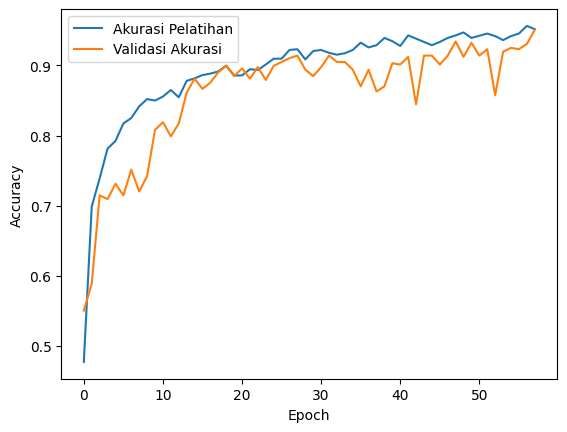

In [15]:
plt.plot(history.history["accuracy"], label="Akurasi Pelatihan")
plt.plot(history.history["val_accuracy"], label="Validasi Akurasi")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

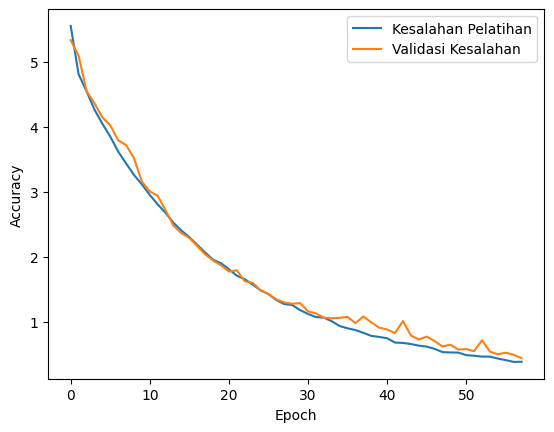

In [16]:
plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 761ms/step


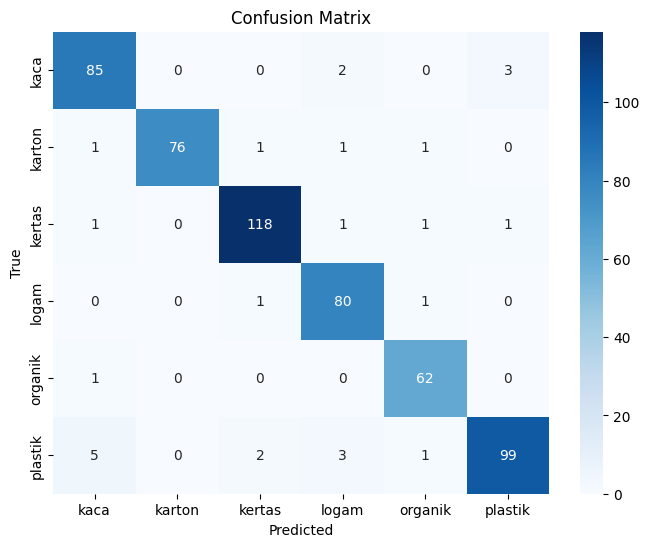

Classification Report:
               precision    recall  f1-score   support

        kaca       0.91      0.94      0.93        90
      karton       1.00      0.95      0.97        80
      kertas       0.97      0.97      0.97       122
       logam       0.92      0.98      0.95        82
     organik       0.94      0.98      0.96        63
     plastik       0.96      0.90      0.93       110

    accuracy                           0.95       547
   macro avg       0.95      0.95      0.95       547
weighted avg       0.95      0.95      0.95       547



In [17]:
true_labels = []
predicted_labels = []

for _ in range(len(val_images)):
    batch_images, batch_labels = next(val_images)
    predictions = model.predict(batch_images)
    true_labels.extend(np.argmax(batch_labels, axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", classification_rep)

In [19]:
from google.colab import output
from IPython.display import display, Javascript, Image
from base64 import b64decode
import cv2
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

dataset = pd.read_csv("datasetnew.csv", delimiter=';')

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        takePhoto({quality});
    ''')
    display(js)
    data = output.eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

photo_filename = take_photo()

preprocessed_image = preprocess_image(photo_filename)

predictions = model.predict(preprocessed_image)

predicted_class = np.argmax(predictions)

class_indices = train_images.class_indices
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class]
print(f'Sampah {predicted_class_name}')

for index, row in dataset.iterrows():
    if row['nama'] == predicted_class_name:
        print(f"Jenis Sampah: {row['jenis']}")
        print(f"Cara Penanganan: {row['cara_penanganan']}")
        print(f"Deskripsi: {row['deskripsi']}")


<IPython.core.display.Javascript object>

1/1 [==============================] - 1s 723ms/step
Sampah karton
Jenis Sampah: anorganik
Cara Penanganan: Kerajinan Miniatur Rumah,Kardus bekas dapat dijadikan bahan baku untuk membuat kerajinan miniatur rumah dengan berbagai desain dan ukuran, Kerajinan Organizer,Kardus bekas dapat diubah menjadi organizer atau laci penyimpanan untuk perkakas atau barang-barang kecil lainnya, Kerajinan Topeng,Kardus bekas dapat digunakan untuk membuat topeng yang kreatif untuk keperluan kostum atau hiburan, Kerajinan Model Bangunan,Kardus bekas dapat dijadikan bahan untuk membuat model bangunan atau struktur untuk proyek sekolah atau tugas, Kerajinan Kotak Kado,Kardus bekas dapat diubah menjadi kotak kado yang unik dengan dekorasi kreatif dan ramah lingkungan, Kertas Daur Ulang,Kardus dapat didaur ulang menjadi kertas daur ulang yang kemudian dapat digunakan kembali untuk mencetak kemasan atau kertas lainnya, Kertas Hias,Kertas daur ulang dapat digunakan untuk membuat kertas hias dengan berbagai des

4. Model Evaluation

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
  f.write(tflite_model)

In [21]:
model.save("model.h5")
print("Keras model saved as 'model.h5'")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Keras model saved as 'model.h5'
